In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [43]:
data = pd.read_csv('./Assets/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,High,Low,Open,Close,Volume,Adj Close,pct_change,log_change,7ma,14ma,...,investment_dif,foreign_buy,foreign_sell,foreign_dif,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010/2/10,52.250000,51.700001,51.950001,52.099998,11219,52.099998,0.010669,0.010613,51.943241,52.708595,...,1454164689,1.551380e+10,2.549564e+10,-9981838210,96.358920,98.341083,94.157682,97.504515,95.290389,94.816094
2010/2/22,53.150002,52.599998,53.049999,52.599998,11187,52.599998,0.009597,0.009551,52.107470,52.693884,...,771651699,2.846749e+10,2.503619e+10,3431302085,96.242195,98.002049,93.597325,95.929373,90.414471,88.712660
2010/2/23,52.750000,52.200001,52.599998,52.599998,9571,52.599998,0.000000,0.000000,52.230624,52.681192,...,-387699136,2.422218e+10,2.360860e+10,613580581,96.125140,97.662731,93.037830,94.352361,85.604138,82.741271
2010/2/24,52.549999,52.150002,52.150002,52.250000,11026,52.250000,-0.006654,-0.006676,52.235469,52.623011,...,483080557,2.027639e+10,2.546846e+10,-5192069643,96.007757,97.323153,92.479275,92.775246,80.907607,76.994296
2010/2/25,52.299999,51.349998,52.250000,51.650002,20361,51.650002,-0.011483,-0.011550,52.089087,52.491931,...,-484640740,2.259238e+10,3.143820e+10,-8845826819,95.890048,96.983341,91.921743,91.199799,76.371194,71.557895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/12/25,119.599998,118.599998,119.099998,118.949997,2801317,118.949997,0.001263,0.001262,118.587579,118.090677,...,373419980,2.930742e+10,2.403325e+10,5274170949,111.049753,127.320992,121.886350,124.377775,120.608542,121.100219
2020/12/28,120.000000,119.050003,119.050003,120.000000,3407442,120.000000,0.008827,0.008789,118.940684,118.345254,...,139024268,5.145881e+10,3.850894e+10,12949871214,111.054398,127.489588,122.247031,124.754413,121.300176,121.903124
2020/12/29,120.199997,119.349998,120.050003,119.900002,3093979,119.900002,-0.000833,-0.000834,119.180513,118.552554,...,-767399344,4.903891e+10,5.029541e+10,-1256508512,111.058523,127.656402,122.607526,125.124296,122.062133,122.757176


In [44]:
data['y'] = data['Close']

x = data.iloc[:, :59].values
y = data.iloc[:, 59].values

split = int(data.shape[0]* 1)
train_x, test_x = x[: split, :], x[split - 20:, :]
train_y, test_y = y[: split, ], y[split - 20: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2665, 59) trainY: (2665,)
testX: (20, 59) testY: (20,)


In [45]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [46]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([59, 400, 400, 400, 10], 10)

[1/300] Loss: 528.4188613891602
[2/300] Loss: 488.19736671447754
[3/300] Loss: 477.33220863342285
[4/300] Loss: 485.2633857727051
[5/300] Loss: 461.6941947937012
[6/300] Loss: 446.9464340209961
[7/300] Loss: 450.99488258361816
[8/300] Loss: 450.6418209075928
[9/300] Loss: 438.72962379455566
[10/300] Loss: 422.7965774536133
[11/300] Loss: 414.12684440612793
[12/300] Loss: 417.7615718841553
[13/300] Loss: 416.3552703857422
[14/300] Loss: 400.85061740875244
[15/300] Loss: 389.15654373168945
[16/300] Loss: 387.04444217681885
[17/300] Loss: 387.3257026672363
[18/300] Loss: 384.9939212799072
[19/300] Loss: 378.7686376571655
[20/300] Loss: 369.0710849761963
[21/300] Loss: 357.5390815734863
[22/300] Loss: 346.75526237487793
[23/300] Loss: 340.07140254974365
[24/300] Loss: 339.49898624420166
[25/300] Loss: 340.77789306640625
[26/300] Loss: 335.39176750183105
[27/300] Loss: 323.6786308288574
[28/300] Loss: 314.11964988708496
[29/300] Loss: 309.68385887145996
[30/300] Loss: 307.96601486206055
[31

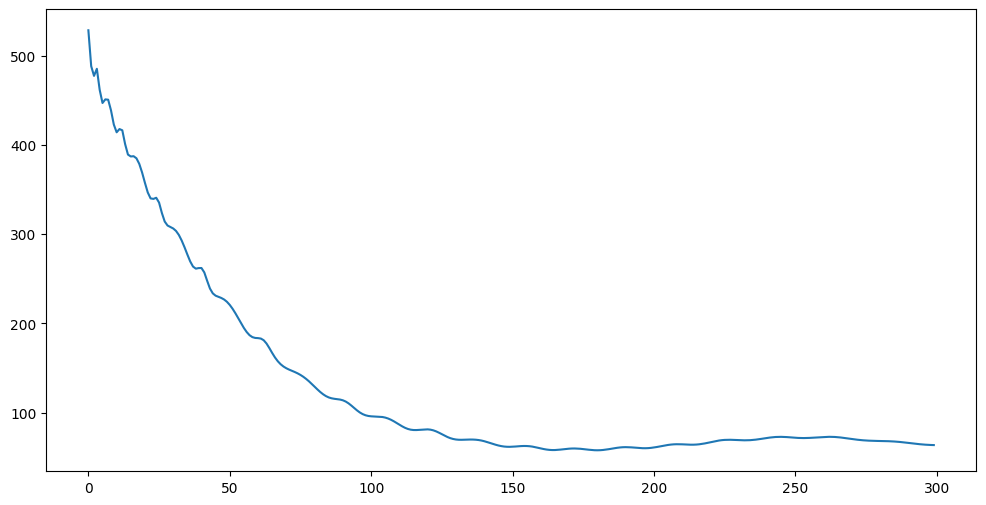

In [47]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [48]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [49]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [50]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [51]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2662, 3, 69]) train_y: torch.Size([2662, 1]) train_y_gan: torch.Size([2662, 4, 1])
test_x: torch.Size([17, 3, 69]) test_y: torch.Size([17, 1]) test_y_gan: torch.Size([17, 4, 1])


In [52]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [53]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(69).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/100] LossD: -0.004999289521947503 LossG:0.10599204013124108
[2/100] LossD: -0.010161865502595901 LossG:0.16027424624189734
[3/100] LossD: -0.012115209363400936 LossG:0.20715990010648966
[4/100] LossD: -0.00877084769308567 LossG:0.237003062851727
[5/100] LossD: 0.00023256707936525345 LossG:0.2505728406831622
[6/100] LossD: 0.008928585797548294 LossG:0.23536166455596685
[7/100] LossD: 0.004426684230566025 LossG:0.22642769571393728
[8/100] LossD: -0.0006269682198762894 LossG:0.21365890093147755
[9/100] LossD: -0.0028609121218323708 LossG:0.20194733794778585
[10/100] LossD: -0.00413800124078989 LossG:0.18737060483545065
[11/100] LossD: -0.0054527767933905125 LossG:0.17624078039079905
[12/100] LossD: -0.007003207225352526 LossG:0.1742404019460082
[13/100] LossD: -0.009051853325217962 LossG:0.16591965267434716
[14/100] LossD: -0.011634259019047022 LossG:0.15545428404584527
[15/100] LossD: -0.015498076565563679 LossG:0.14964751806110144
[16/100] LossD: -0.020948899909853935 LossG:0.1623874

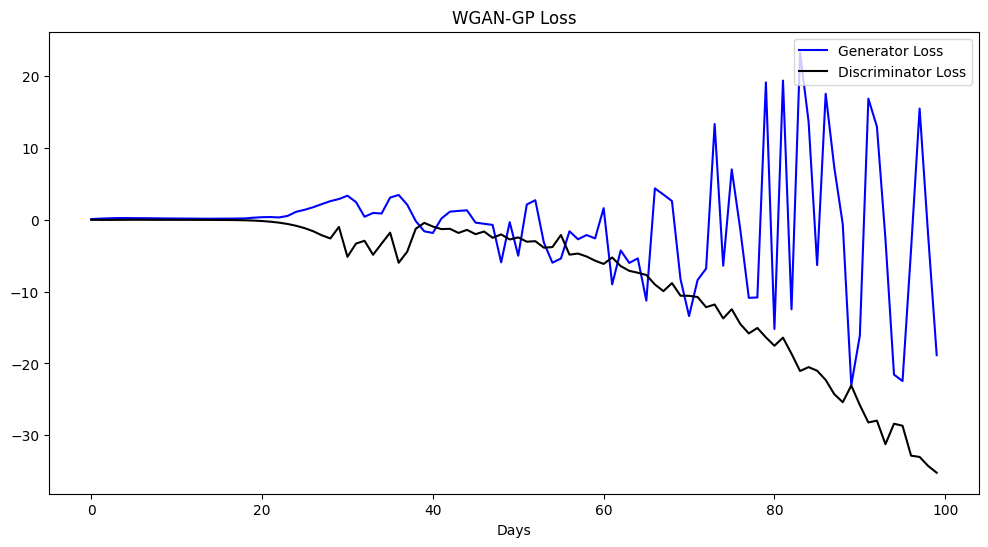

In [54]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [55]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:4.041686707065266


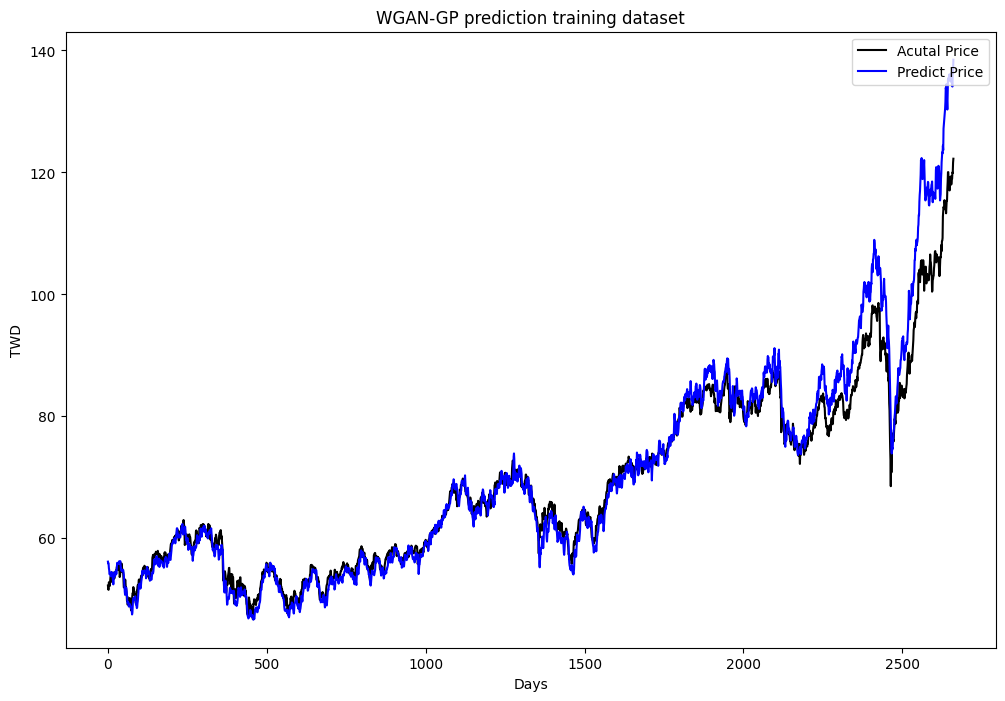

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:16.183785465891386


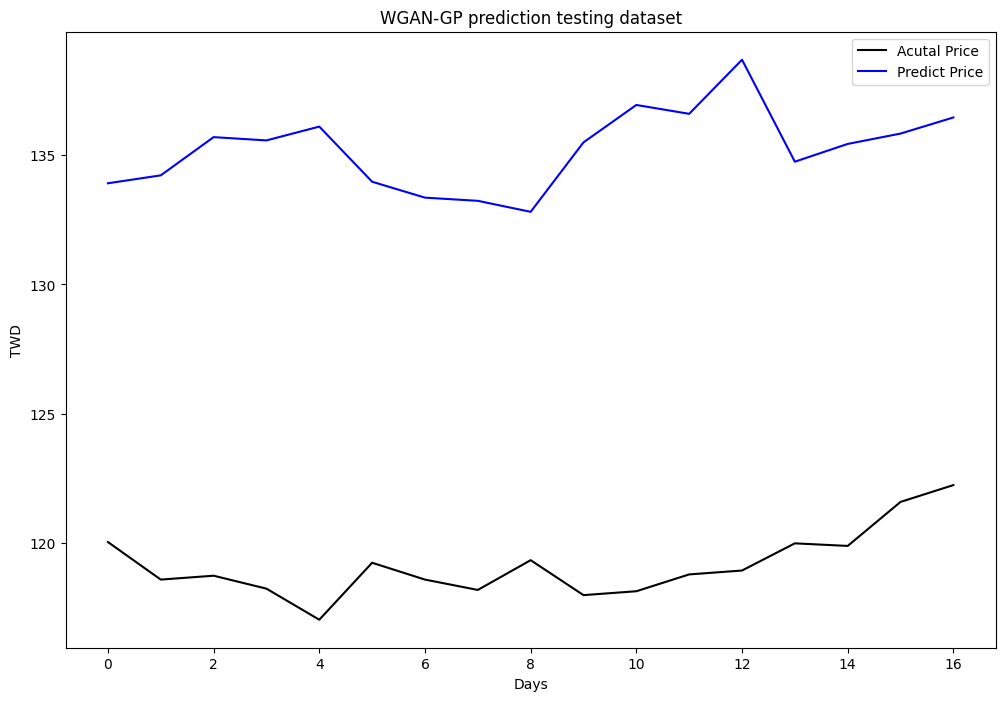

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [58]:


# Function to slide the window over the data
def slide_window(data, window_size):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i+window_size])
    return np.array(X)

# Slide the window over the test data
window_size = 3  # Use the same window size as during training
test_data_windowed = slide_window(test_x, window_size)

# Convert the data to PyTorch tensors and move to device
test_data_windowed_tensor = torch.from_numpy(test_data_windowed).float().to(device)

# Generate predictions for the test data
predictions = modelG(test_data_windowed_tensor)

# Inverse transform the predictions
predictions_inv = y_scaler.inverse_transform(predictions.cpu().detach().numpy())

# Extract the predictions for the next 30 days
predictions_next_30_days = predictions_inv[-30:]

# Print the predictions for the next 30 days
print("Predicted Close Prices for the Next 30 Days:")
print(predictions_next_30_days)


Predicted Close Prices for the Next 30 Days:
[[133.90642]
 [134.21219]
 [135.68848]
 [135.56207]
 [136.09555]
 [133.96573]
 [133.35155]
 [133.2288 ]
 [132.80371]
 [135.48631]
 [136.93102]
 [136.58885]
 [138.67834]
 [134.73961]
 [135.42606]
 [135.82608]
 [136.44815]
 [138.2955 ]]


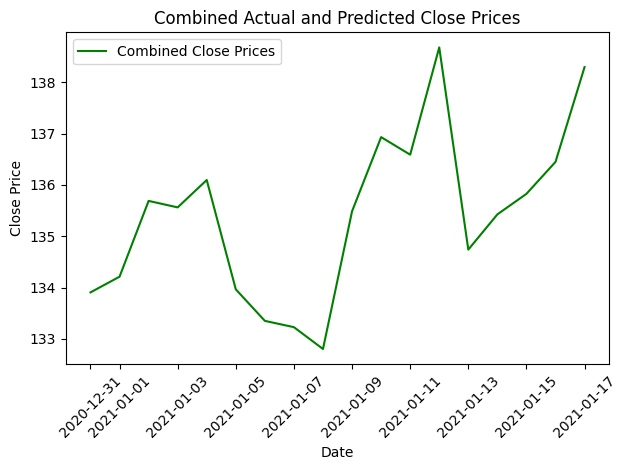

In [68]:
# Create a DataFrame with the predicted values and corresponding dates
predicted_dates = pd.date_range(start=start_date, periods=len(predictions_next_30_days), freq='D')
predicted_data = pd.DataFrame({'Date': predicted_dates, 'Close': predictions_next_30_days.flatten()})  # Flatten the predictions

# Concatenate the original dataset and the predicted values DataFrame
combined_data = pd.concat([data, predicted_data], ignore_index=True)

# Plot the combined dataset
plt.plot(combined_data['Date'], combined_data['Close'], label='Combined Close Prices', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Combined Actual and Predicted Close Prices')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


In [69]:
print(combined_data)

           High        Low       Open       Close   Volume  Adj Close  \
0     52.250000  51.700001  51.950001   52.099998  11219.0  52.099998   
1     53.150002  52.599998  53.049999   52.599998  11187.0  52.599998   
2     52.750000  52.200001  52.599998   52.599998   9571.0  52.599998   
3     52.549999  52.150002  52.150002   52.250000  11026.0  52.250000   
4     52.299999  51.349998  52.250000   51.650002  20361.0  51.650002   
...         ...        ...        ...         ...      ...        ...   
2678        NaN        NaN        NaN  134.739609      NaN        NaN   
2679        NaN        NaN        NaN  135.426056      NaN        NaN   
2680        NaN        NaN        NaN  135.826080      NaN        NaN   
2681        NaN        NaN        NaN  136.448151      NaN        NaN   
2682        NaN        NaN        NaN  138.295502      NaN        NaN   

      pct_change  log_change        7ma       14ma  ...  foreign_sell  \
0       0.010669    0.010613  51.943241  52.708595

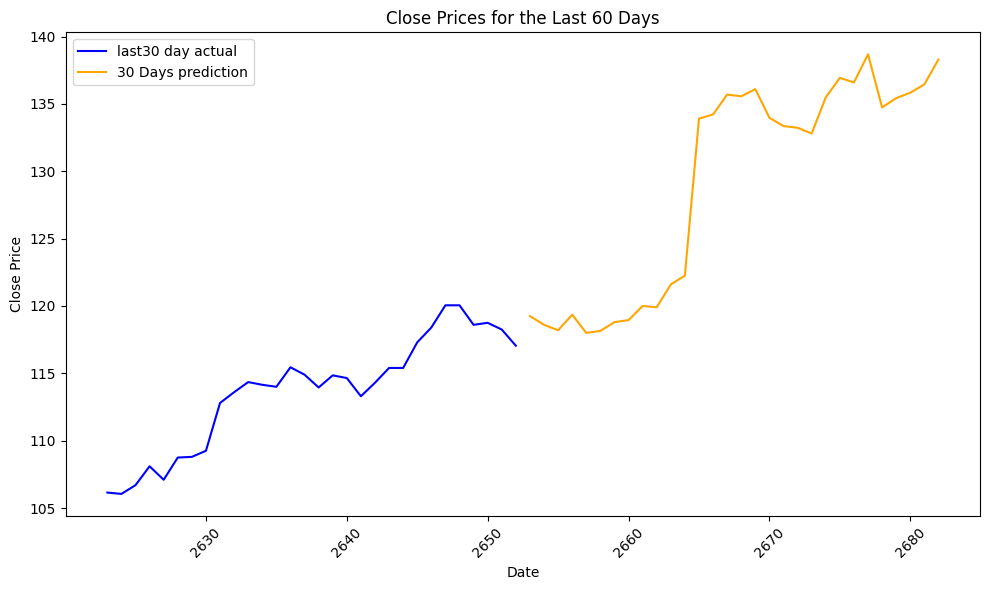

In [90]:
import seaborn as sns

# Select the last 60 days of data
last_60_days = combined_data.iloc[-60:]

# Split the last 60 days into two subsets: first 30 days and last 30 days
first_30_days = last_60_days.iloc[:30]
last_30_days = last_60_days.iloc[30:]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the first 30 days in one color
sns.lineplot(data=first_30_days['Close'], color='blue', label='last30 day actual')

# Plot the last 30 days in another color
sns.lineplot(data=last_30_days['Close'], color='orange', label='30 Days prediction')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices for the Last 60 Days')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [89]:
# Select the last 40 days of data
last_40_days = combined_data.iloc[-40:]

# Check for NaN values in the "Close" column of the last 40 days
last_40_days_nan = last_40_days[last_40_days['Close'].isna()]

# Print the rows with NaN values
if not last_40_days_nan.empty:
    print("Rows with NaN values in the last 40 days:")
    print(last_40_days_nan)
else:
    print("No NaN values found in the last 40 days.")


No NaN values found in the last 40 days.
